In [19]:
# import libraries
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from datetime import datetime

In [20]:
# read in credentials
f = open('credentials.txt', 'r')
contents = f.readlines()
f.close()

client_id = contents[0][:-1]
client_secret = contents[1][:-1]
auth_user_id = contents[2][:-1]
redirect_uri = contents[3]

In [21]:
# establish Spotify client credentials manager
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [22]:
# define playlist class
class Playlist:
    def __init__(self, pl_link):
        self.playlist_id = pl_link[34:]  # Playlist ID
        self.name = sp.playlist(self.playlist_id)['name']  # playlist name
        self.song_ids = self.get_song_ids()


    def get_song_ids(self):
        song_ids = []  # List of song IDs
        song_info = []  # Array of songs and their features
        offset = 0

        while True:
            items = sp.playlist_items(self.playlist_id, offset=offset)['items']
            for item in items:
                track = item['track']
                song_ids.append(track['id'])
            if len(items) >= 100:
                offset += 100
            else:
                break
        return song_ids
    
    def get_meta_df(self):
        song_info = []

        for id in self.song_ids:
            meta = sp.track(id)

            # meta data
            name = meta['name']
            id = meta['id']
            artist = meta['album']['artists'][0]['name']
            artist_id = meta['album']['artists'][0]['id']


            # release year
            release_year = int(meta['album']['release_date'][:4])

            song_features = [name, id, artist, artist_id, release_year]

            song_info.append(song_features)

        df = pd.DataFrame(song_info, columns=['name', 'id', 'artist', 'artist_id','release_year'])
        return df
    
    def get_audio_df(self):
        song_info = []

        for id in self.song_ids:
            features = sp.audio_features(id)

            # audio data
            loudness = features[0]['loudness']
            time_signature = features[0]['time_signature']
            tempo = features[0]['tempo']
            mode = features[0]['mode']
            key = features[0]['key']

            acousticness = features[0]['acousticness']
            danceability = features[0]['danceability']
            energy = features[0]['energy']
            instrumentalness = features[0]['instrumentalness']
            liveness = features[0]['liveness']
            speechiness = features[0]['speechiness']
            valence = features[0]['valence']

            song_features = [id, loudness, time_signature, tempo, mode, key,
                           danceability, energy, valence,
                           acousticness, instrumentalness, liveness, speechiness]

            song_info.append(song_features)

   
        df = pd.DataFrame(song_info, columns=['id', 'loudness', 'time_signature', 'tempo', 'mode', 'key',
                                        'danceability', 'energy', 'valence',
                                        'acousticness', 'instrumentalness', 'liveness', 'speechiness'])
        return df

    def get_genre_counts(self):
        artist_ids = list(self.get_meta_df()['artist_id'])

        genres = {}    # genre_name: count

        for artist_id in artist_ids:
            artist_info = sp.artist(artist_id)
            artist_genres = artist_info['genres']
            for genre in artist_genres:
                if genre in genres:
                    genres[genre] += 1
                else:
                    genres[genre] = 1
        return genres

In [23]:
# plot audio metrics
def plot_metrics(dataframe):
    dance = list(dataframe["danceability"])
    energy = list(dataframe["energy"])
    valence = list(dataframe["valence"])
    acoustic = list(dataframe["acousticness"])
    instrument = list(dataframe["instrumentalness"])
    liveness = list(dataframe["liveness"])
    speech = list(dataframe["speechiness"])
    
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, _, _)) = plt.subplots(nrows=3, ncols=3, figsize=(16, 9))

    ax1.hist(dance, color = "red", ec = "black")
    ax1.set_title("Danceability", fontsize = 16)
    ax1.set_ylabel("Frequency", fontsize = 16)
    
    ax2.hist(energy, color = "orange", ec = "black")
    ax2.set_title("Energy", fontsize = 16)
    ax2.set_xlabel("Values", fontsize = 16)

    ax3.hist(valence, color = "yellow", ec = "black")
    ax3.set_title("Valence", fontsize = 16)
    
    ax4.hist(acoustic, color = "green", ec = "black")
    ax4.set_title("Acousticness", fontsize = 16)
    ax4.set_ylabel("Frequency", fontsize = 16)
    
    ax5.hist(instrument, color = "blue", ec = "black")
    ax5.set_title("Instrumentalness", fontsize = 16)
    ax5.set_xlabel("Values", fontsize = 16)

    ax6.hist(liveness, color = "purple", ec = "black")
    ax6.set_title("Liveness", fontsize = 16)
    
    ax7.hist(speech, color = "pink", ec = "black")
    ax7.set_title("Speechiness", fontsize = 16)
    ax7.set_ylabel("Frequency", fontsize = 16)
    ax2.set_xlabel("Values", fontsize = 16)
    
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    
    plt.show()

In [24]:
# plot main genres
def plot_genre(genre_freq):
    # Combine genres with frequency of 1 into an "Other" category
    other_count = 0
    processed_genre_freq = {}
    
    for genre, freq in genre_freq.items():
        if freq == 1:
            other_count += 1
        else:
            processed_genre_freq[genre] = freq
    
#     if other_count > 0:
#         processed_genre_freq['Miscellaneous'] = other_count
    
    genres = list(processed_genre_freq.keys())
    frequencies = list(processed_genre_freq.values())
    
    palette = plt.get_cmap("tab20")
    
    plt.figure(figsize=(15, 10))  # Adjust figure size here
    plt.barh(genres, frequencies, color = palette.colors)
    plt.title("Genre Frequency", fontsize = 18)
    plt.ylabel("Main Genres", fontsize = 18)
    
    plt.xticks(np.arange(0, max(frequencies) + 1, 5))
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()

    plt.show()

In [25]:
# plot the top 20 genres
def plot_genre(genre_freq):
    # Combine genres with frequency of 1 into an "Other" category
    other_count = sum(1 for freq in genre_freq.values() if freq == 1)
    processed_genre_freq = {genre: freq for genre, freq in genre_freq.items() if freq > 1}
    
    if other_count > 0:
        processed_genre_freq['Other'] = other_count
    
    # Sort genres by frequency and select top ten
    sorted_genres = sorted(processed_genre_freq.items(), key=lambda x: x[1], reverse=True)[:20]
    genres = [genre[0] for genre in sorted_genres]
    frequencies = [genre[1] for genre in sorted_genres]
    
    palette = plt.get_cmap("tab20")

    plt.figure(figsize=(12, 8))  # Adjust figure size here
    plt.barh(genres, frequencies, color=palette.colors)
    plt.title("Top Genre Frequencies", fontsize=18)
    plt.xlabel("Frequency", fontsize=15)
    plt.ylabel("Main Genres", fontsize=15)
    
    # Set x-axis ticks to go by counts of 5
    plt.xticks(np.arange(0, max(frequencies) + 1, 5))
    
    # Add gridlines
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()

    plt.show()

In [26]:
# plot main artists
def plot_artists(meta_df):
    artist_list = []
    for artist in meta_df["artist"]:
        artist_list.append(artist)

    artist_count = Counter(artist_list)
    
    other_count = 0
    processed_artist_count = {}

    for artist, count in artist_count.items():
        if count == 1:
            other_count += 1
        else:
            processed_artist_count[artist] = count

#     if other_count > 0:
#         processed_artist_count['Other'] = other_count

    artists = list(processed_artist_count.keys())
    artist_freq = list(processed_artist_count.values())

    palette = plt.get_cmap("tab20")

    plt.barh(artists, artist_freq, color = palette.colors)
    plt.title("Artist Frequency", fontsize = 18)
    plt.xlabel("Count", fontsize = 18)
    plt.ylabel("Main Artists", fontsize = 18)
    
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()

In [27]:
# plot top 20 most artists
def plot_artists(meta_df):
    artist_list = meta_df["artist"].tolist()

    # Count the frequency of each artist
    artist_count = Counter(artist_list)
    
    # Sort artists by frequency and select top 20
    sorted_artists = sorted(artist_count.items(), key=lambda x: x[1], reverse=True)[:20]
    artists = [artist[0] for artist in sorted_artists]
    artist_freq = [artist[1] for artist in sorted_artists]

    palette = plt.get_cmap("tab20")

    plt.figure(figsize=(12, 8))  # Adjust figure size here
    plt.barh(artists, artist_freq, color=palette.colors)
    plt.title("Most Frequent Artists", fontsize=18)
    plt.xlabel("Count", fontsize=15)
    plt.ylabel("Artists", fontsize=15)
    
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [28]:
# plot release years
def plot_release_years(meta_df):
    # Extract release years into a list
    release_years = meta_df["release_year"].astype(int).tolist()

    # Count the frequency of each release year
    year_count = Counter(release_years)
    
    # Sort the years and their frequencies by year
    sorted_years = sorted(year_count.keys())
    frequencies = [year_count[year] for year in sorted_years]

    # Create the bar plot
    plt.figure(figsize=(12, 8))
    plt.bar(sorted_years, frequencies, color='skyblue')

    # Add title and labels
    plt.title("Frequency of Release Years", fontsize=18)
    plt.xlabel("Release Year", fontsize=15)
    plt.ylabel("Frequency", fontsize=15)
    
    plt.xticks(np.arange(min(sorted_years) - 1, max(sorted_years) + 1, 1))
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()


In [10]:
# demo
gore_link = 'https://open.spotify.com/playlist/6ZzIjm5JGybGSWpkWeZXtd'
gore = Playlist(gore_link)

In [11]:
gore.name

'gore'

In [12]:
gore.playlist_id

'6ZzIjm5JGybGSWpkWeZXtd'

In [14]:
len(gore.song_ids)

548

In [16]:
gore_meta = gore.get_meta_df()   # 1:16.41
gore_meta

,name,id,artist,artist_id,release_year
0,Prima Nocte,43IT7qGFqv8jwJ9rT8GyeP,Devalued,3PgQ8WfMRqb3QBSjWPoEUs,2022
1,Psalms,1JLn2SWy6w2KPgEvjepcNK,Devalued,3PgQ8WfMRqb3QBSjWPoEUs,2022
2,Cerberus,6bsRDzPCReB7RYAjCTaxgE,Devalued,3PgQ8WfMRqb3QBSjWPoEUs,2022
3,Colossus,6w9UJ1kdr4ON9NpqIeACmW,Devalued,3PgQ8WfMRqb3QBSjWPoEUs,2022
4,Copper Hand,3Yd3XczPUVYrD1MbobxHHs,Devalued,3PgQ8WfMRqb3QBSjWPoEUs,2022
...,...,...,...,...,...
543,The Call Of Ktulu (Remastered),5zZ74lczJgFtVCeaS11Fo1,Metallica,2ye2Wgw4gimLv2eAKyk1NB,1984
544,Am I Evil? (Remastered),4PVipA5hOmX3Su0pQJNt7Y,Metallica,2ye2Wgw4gimLv2eAKyk1NB,1984
545,Battery (Remastered),7qRxAH7ZRB2Ita3mebXfR3,Metallica,2ye2Wgw4gimLv2eAKyk1NB,1986
546,Deimos,725KmazNobzYJQ364AAgld,Hive,5DA5dDq3y1s10tuBK4HVn6,2022


In [17]:
gore_audio = gore.get_audio_df()    # 0:50.78
gore_audio

,id,loudness,time_signature,tempo,mode,key,danceability,energy,valence,acousticness,instrumentalness,liveness,speechiness
0,43IT7qGFqv8jwJ9rT8GyeP,-6.081,4,84.842,0,11,0.119,0.911,0.1840,0.000074,0.8840,0.0984,0.0915
1,1JLn2SWy6w2KPgEvjepcNK,-5.588,4,87.598,1,11,0.293,0.958,0.5340,0.000006,0.7650,0.1330,0.0978
2,6bsRDzPCReB7RYAjCTaxgE,-6.514,3,174.247,1,1,0.173,0.782,0.1190,0.000044,0.7290,0.1380,0.1530
3,6w9UJ1kdr4ON9NpqIeACmW,-6.009,4,123.896,1,11,0.271,0.910,0.0842,0.000019,0.9470,0.1810,0.1390
4,3Yd3XczPUVYrD1MbobxHHs,-5.206,3,120.080,1,9,0.188,0.898,0.1800,0.000005,0.9710,0.1100,0.0915
...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,5zZ74lczJgFtVCeaS11Fo1,-7.584,4,139.239,0,9,0.301,0.935,0.1450,0.022100,0.8540,0.2150,0.1000
544,4PVipA5hOmX3Su0pQJNt7Y,-5.703,4,78.711,1,4,0.295,0.926,0.5200,0.000301,0.3750,0.0522,0.0851
545,7qRxAH7ZRB2Ita3mebXfR3,-8.793,4,96.535,0,11,0.480,0.923,0.4400,0.000211,0.5310,0.1060,0.0682
546,725KmazNobzYJQ364AAgld,-3.563,4,180.054,1,1,0.447,0.945,0.3600,0.000120,0.0358,0.3160,0.1680


In [19]:
gore_genres = gore.get_genre_counts()    # 2:07.41
gore_genres

{'alternative metal': 174,
 'death metal': 58,
 'groove metal': 174,
 'hard rock': 101,
 'metal': 220,
 'old school thrash': 63,
 'rock': 78,
 'speed metal': 51,
 'thrash metal': 54,
 'french death metal': 31,
 'french metal': 31,
 'nu metal': 118,
 'progressive groove metal': 82,
 'alternative rock': 9,
 'grunge': 9,
 'post-hardcore': 10,
 'punk': 9,
 'sludge metal': 73,
 'stoner metal': 41,
 'doom metal': 49,
 'louisiana metal': 33,
 'southern metal': 31,
 'industrial metal': 8,
 'supergroup': 1,
 'atlanta metal': 23,
 'progressive sludge': 27,
 'stoner rock': 29,
 'drone metal': 16,
 'uk doom metal': 8,
 'djent': 121,
 'swedish metal': 40,
 'technical groove metal': 31,
 'technical thrash': 28,
 'melodic thrash': 5,
 'epic doom': 3,
 'opera metal': 3,
 'swedish doom metal': 7,
 'texas metal': 20,
 'funk metal': 2,
 'instrumental rock': 24,
 'shred': 2,
 'virginia metal': 13,
 'dissonant death metal': 20,
 'florida death metal': 23,
 'technical death metal': 33,
 'atmospheric post-me

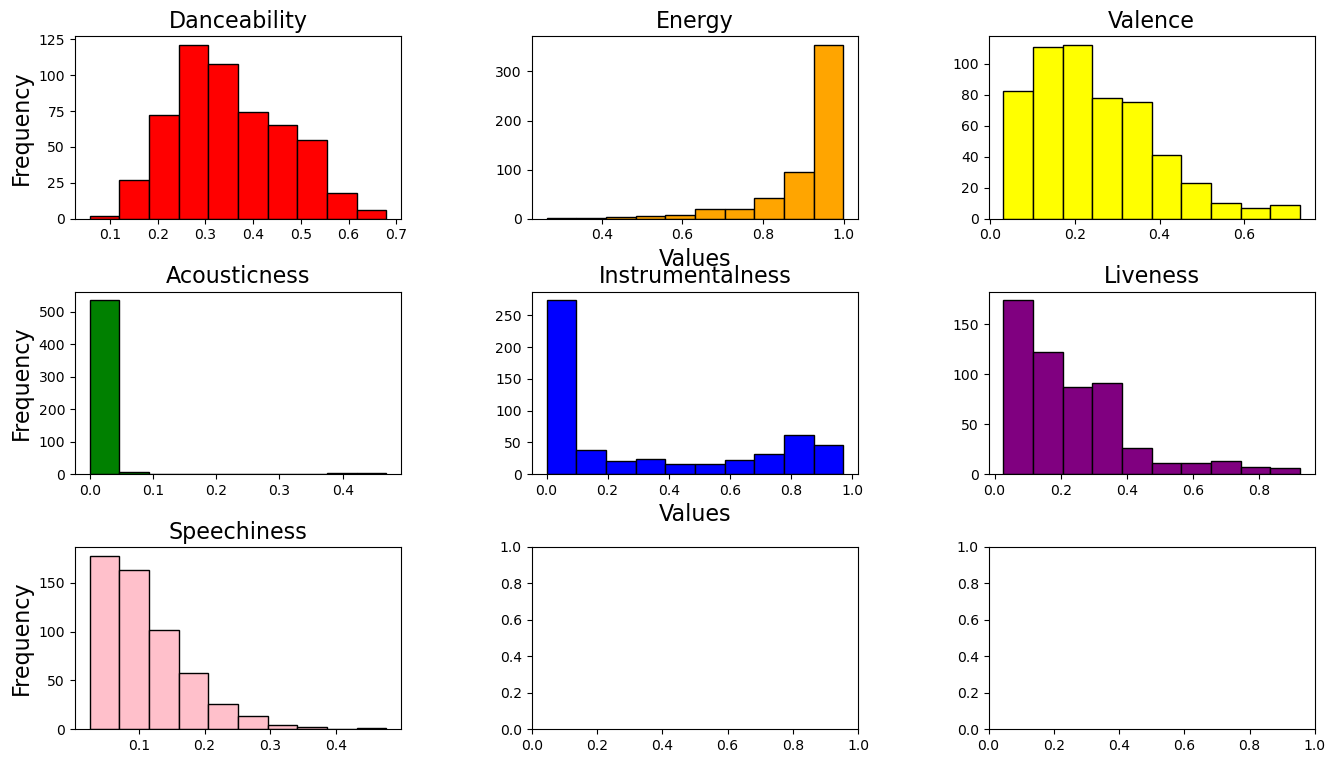

In [23]:
plot_metrics(gore_audio)

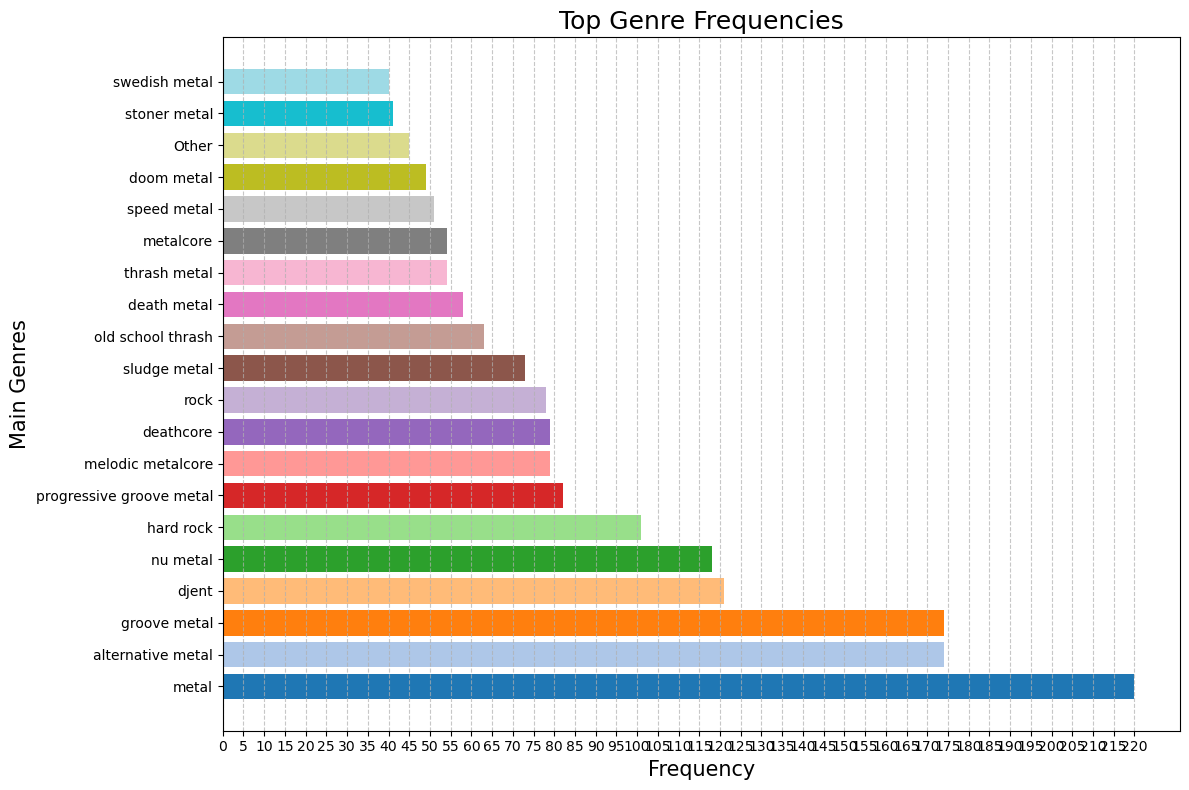

In [34]:
plot_genre(gore_genres)

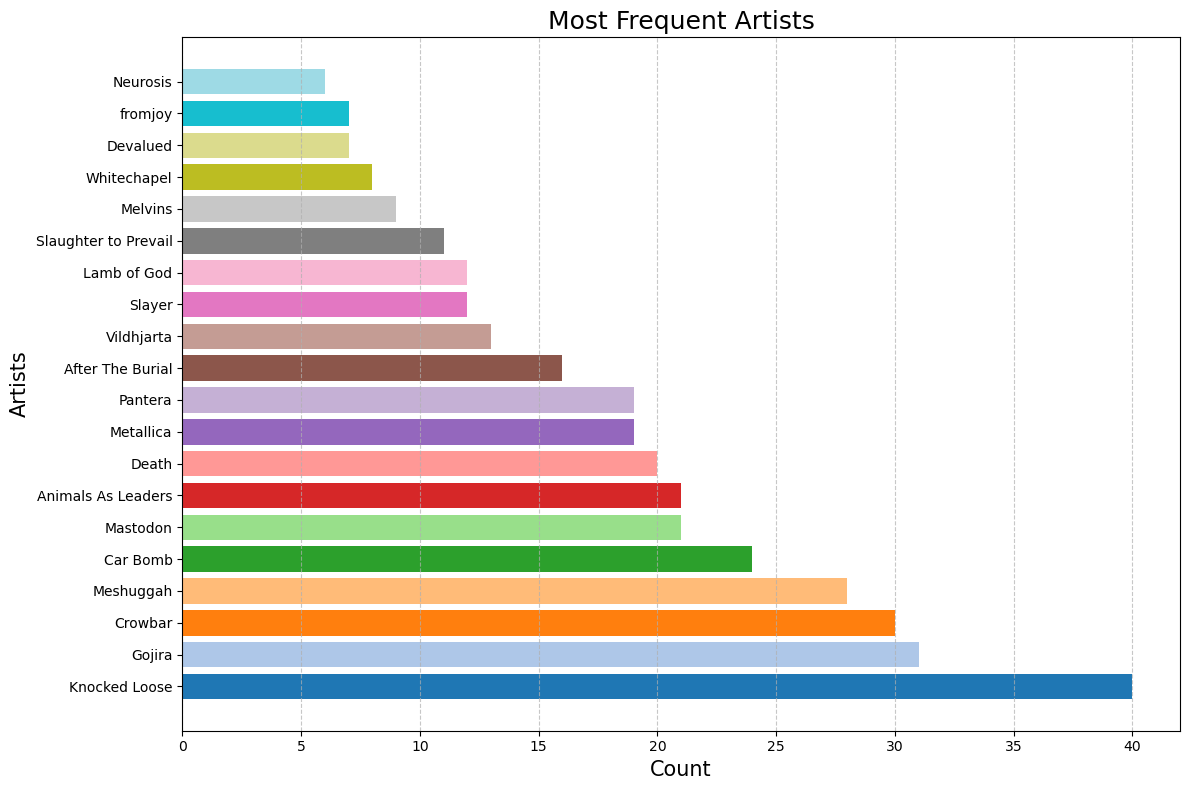

In [45]:
plot_artists(gore_meta)

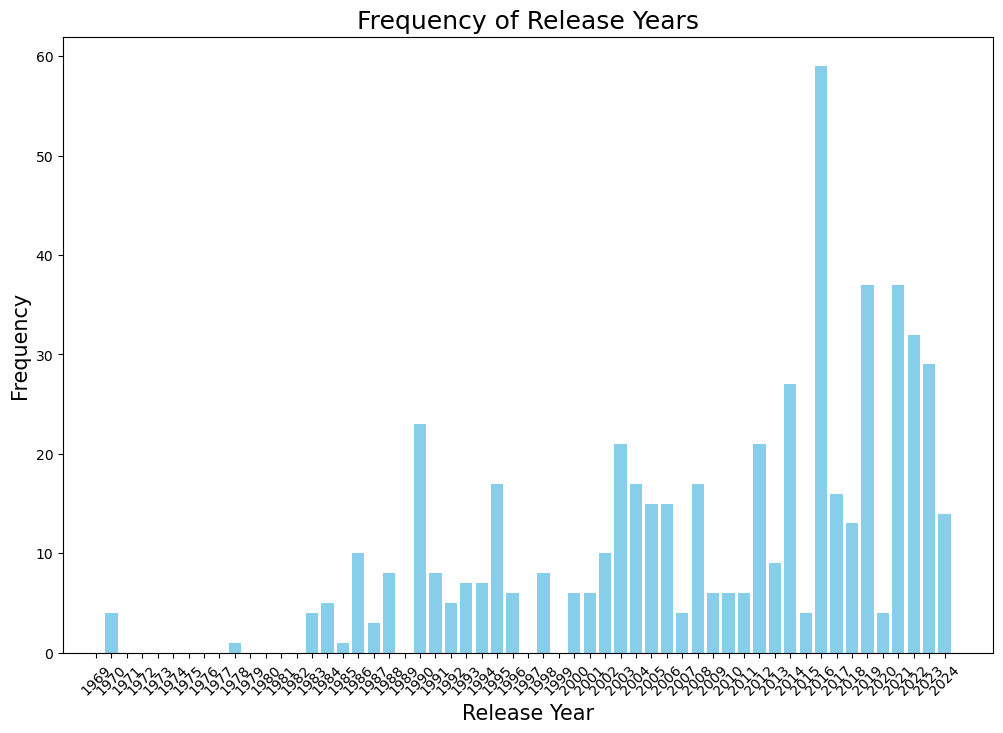

In [40]:
plot_release_years(gore_meta)

In [15]:
# demo 2
ecstasy_link = 'https://open.spotify.com/playlist/1E3n5a6F47RNNvvI3OGzJp'
ec = Playlist(ecstasy_link)

In [19]:
# audio = ec.get_audio_df()
# audio

In [20]:
# meta = ec.get_meta_df()
# meta

In [13]:
type({2:1, 2:2,3:3})

dict

In [17]:
type({ 'a': [1,2,3], 'b': {'x': 3}})

dict

In [11]:
# demo 2
ecstacy_link = 'https://open.spotify.com/playlist/1E3n5a6F47RNNvvI3OGzJp'
ecs = Playlist(ecstacy_link)

In [12]:
ecs_meta = ecs.get_meta_df()
ecs_meta

,name,id,artist,artist_id,release_year
0,Show Me How,01TyFEZu6mHbffsVfxgrFn,Men I Trust,3zmfs9cQwzJl575W1ZYXeT,2018
1,Plants,0vMr3GXZJi1IIIWE8bBJuZ,Crumb,4kSGbjWGxTchKpIxXPJv0B,2017
2,Teardrop,67Hna13dNDkZvBpTXRIaOJ,Massive Attack,6FXMGgJwohJLUSr5nVlf9X,1998
3,It's Over Again,660eXTPUwKkCOYvWIr6sPl,Mild High Club,5J81VungUjSVHxlPpTI9KG,2021
4,Tommy's Party,5OuJTtNve7FxUX82eEBupN,Peach Pit,6fC2AcsQtd9h4BWELbbire,2018
...,...,...,...,...,...
449,Peace,1E07JVm6RenaKcAEKtfjKu,Dave Bixby,42VyrHFegrrMrYwq8CuG1r,1969
450,the rot,3ESXgEbWaaoCJcHkiG6yF1,Dean Blunt,5CFSYjc0PAiQvndFjafabk,2021
451,100,784VjdNkpXhFV0RHquzsi2,Dean Blunt,5CFSYjc0PAiQvndFjafabk,2014
452,Luna - En Vivo,7b3k8I1fncAzbk9PHnLkbX,Zoé,6IdtcAwaNVAggwd6sCKgTI,2011


In [13]:
ecs_audio = ecs.get_audio_df()
ecs_audio

,id,loudness,time_signature,tempo,mode,key,danceability,energy,valence,acousticness,instrumentalness,liveness,speechiness
0,01TyFEZu6mHbffsVfxgrFn,-11.997,4,165.990,1,5,0.791,0.2670,0.5440,0.674000,0.534000,0.102,0.0415
1,0vMr3GXZJi1IIIWE8bBJuZ,-10.725,4,81.030,0,11,0.494,0.4060,0.2220,0.607000,0.496000,0.122,0.0411
2,67Hna13dNDkZvBpTXRIaOJ,-8.800,4,76.997,0,11,0.615,0.4190,0.2160,0.017300,0.497000,0.135,0.0395
3,660eXTPUwKkCOYvWIr6sPl,-7.447,4,96.221,1,5,0.655,0.7170,0.5010,0.327000,0.731000,0.102,0.0370
4,5OuJTtNve7FxUX82eEBupN,-8.722,4,133.949,1,7,0.565,0.4380,0.2110,0.122000,0.046900,0.108,0.0311
...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,1E07JVm6RenaKcAEKtfjKu,-20.509,4,64.597,1,11,0.312,0.0756,0.0648,0.853000,0.328000,0.109,0.0384
450,3ESXgEbWaaoCJcHkiG6yF1,-8.244,4,104.619,1,6,0.337,0.7800,0.4720,0.296000,0.281000,0.117,0.0784
451,784VjdNkpXhFV0RHquzsi2,-6.470,4,102.205,0,10,0.613,0.8070,0.4820,0.000406,0.065000,0.267,0.0246
452,7b3k8I1fncAzbk9PHnLkbX,-9.327,3,180.089,0,9,0.230,0.4590,0.1500,0.122000,0.001390,0.741,0.0316


In [14]:
ecs_genres = ecs.get_genre_counts()
ecs_genres

{'indie pop': 71,
 'pov: indie': 79,
 'neo-psychedelic': 41,
 'downtempo': 2,
 'electronica': 16,
 'trip hop': 14,
 'indie garage rock': 12,
 'vancouver indie': 1,
 'modern dream pop': 6,
 'newcastle nsw indie': 6,
 'lgbtq+ hip hop': 5,
 'neo soul': 6,
 'bedroom pop': 39,
 'alternative dance': 6,
 'french indie pop': 2,
 'indietronica': 16,
 'neo-synthpop': 3,
 'new rave': 3,
 'socal pop punk': 2,
 'australian psych': 8,
 'modern rock': 13,
 'rock': 44,
 'alternative r&b': 10,
 'art pop': 31,
 'escape room': 7,
 'indie soul': 11,
 'metropopolis': 11,
 'alaska indie': 1,
 'modern indie pop': 4,
 'afrofuturism': 8,
 'brooklyn indie': 5,
 'sped up': 1,
 'liverpool indie': 7,
 'alternative hip hop': 2,
 'drumless hip hop': 2,
 'experimental hip hop': 1,
 'hip hop': 4,
 'rap': 4,
 'underground hip hop': 1,
 'edmonton indie': 5,
 'lo-fi indie': 11,
 'slacker rock': 12,
 'uk contemporary r&b': 4,
 'hypnagogic pop': 6,
 'chicago rap': 1,
 'baltimore indie': 3,
 'dream pop': 23,
 'dreamo': 9,
 

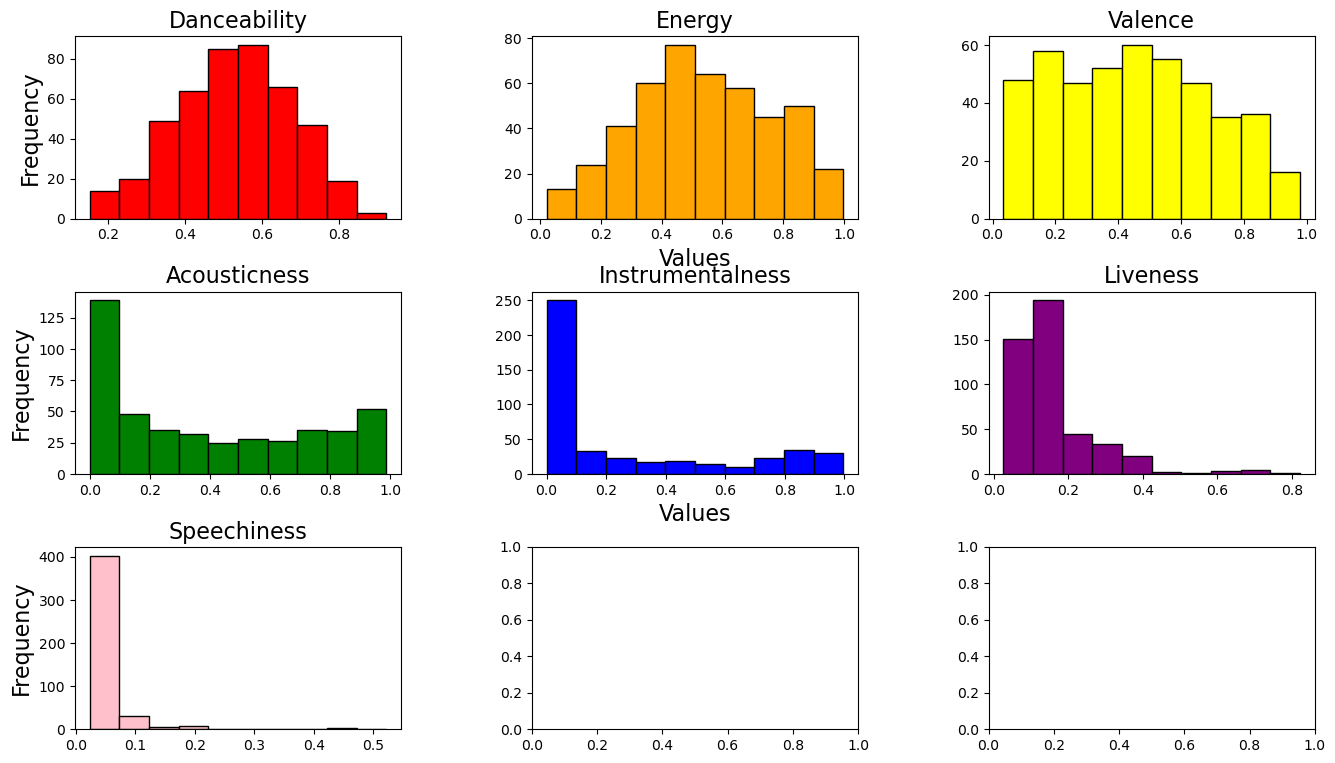

In [17]:
plot_metrics(ecs_audio)

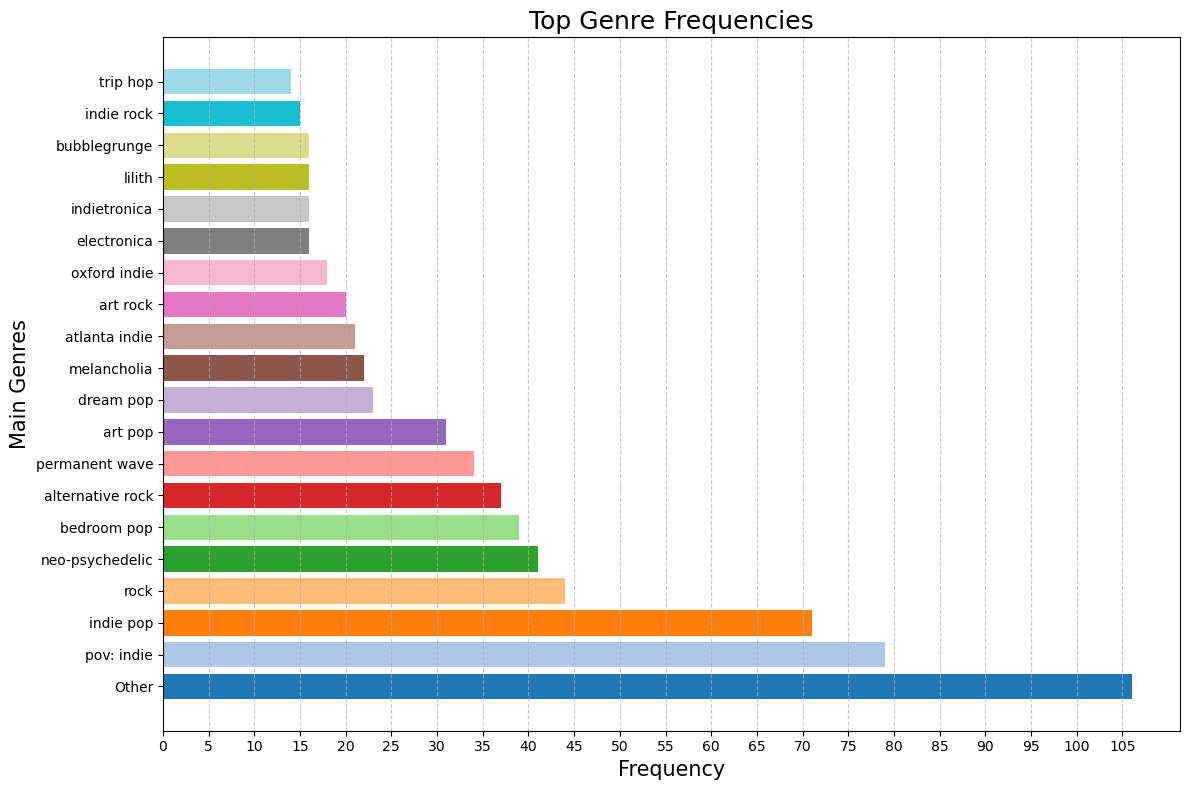

In [33]:
plot_genre(ecs_genres)

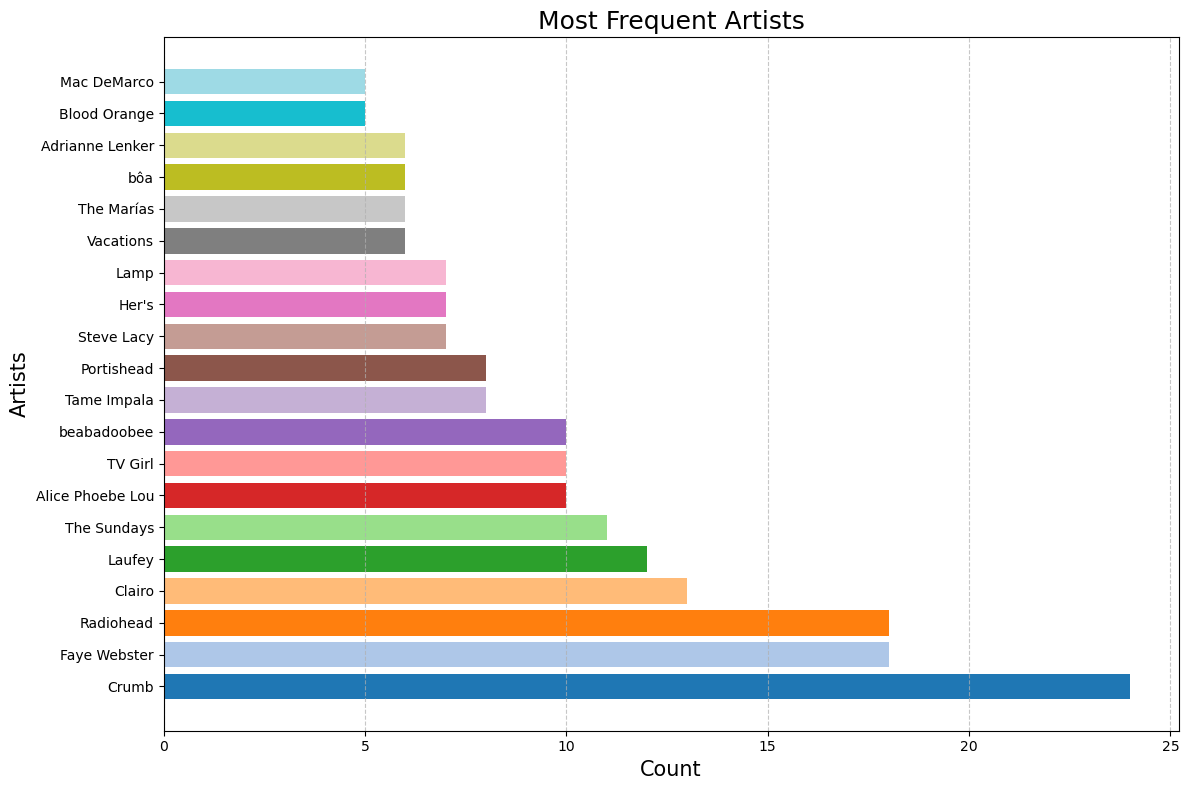

In [30]:
plot_artists(ecs_meta)

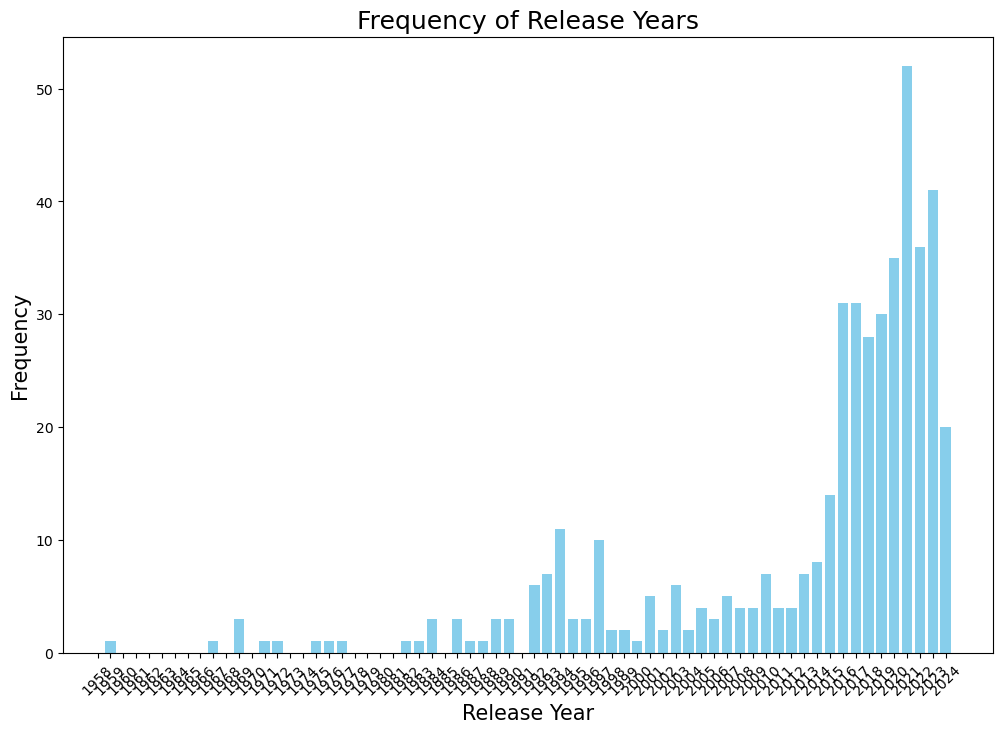

In [32]:
plot_release_years(ecs_meta)

In [51]:
ecs_meta

,name,id,artist,artist_id,release_year
0,Show Me How,01TyFEZu6mHbffsVfxgrFn,Men I Trust,3zmfs9cQwzJl575W1ZYXeT,2018
1,Plants,0vMr3GXZJi1IIIWE8bBJuZ,Crumb,4kSGbjWGxTchKpIxXPJv0B,2017
2,Teardrop,67Hna13dNDkZvBpTXRIaOJ,Massive Attack,6FXMGgJwohJLUSr5nVlf9X,1998
3,It's Over Again,660eXTPUwKkCOYvWIr6sPl,Mild High Club,5J81VungUjSVHxlPpTI9KG,2021
4,Tommy's Party,5OuJTtNve7FxUX82eEBupN,Peach Pit,6fC2AcsQtd9h4BWELbbire,2018
...,...,...,...,...,...
449,Peace,1E07JVm6RenaKcAEKtfjKu,Dave Bixby,42VyrHFegrrMrYwq8CuG1r,1969
450,the rot,3ESXgEbWaaoCJcHkiG6yF1,Dean Blunt,5CFSYjc0PAiQvndFjafabk,2021
451,100,784VjdNkpXhFV0RHquzsi2,Dean Blunt,5CFSYjc0PAiQvndFjafabk,2014
452,Luna - En Vivo,7b3k8I1fncAzbk9PHnLkbX,Zoé,6IdtcAwaNVAggwd6sCKgTI,2011


In [52]:
ecs.name

'ecstasy'

In [53]:
ecs.playlist_id

'1E3n5a6F47RNNvvI3OGzJp'